This notebook is to test the changes proposed in https://github.com/CLIMADA-project/climada_python/tree/feature/tc_holland_vtrans. Let the code run for this branch and the development branch to get the results of the comparison.

In [1]:
import os
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
from  scipy.stats import linregress 

from climada.hazard import TCTracks, TropCyclone
import climada
from climada.util.api_client import Client
client = Client()

In [2]:
cwd_temp = os.getcwd()
climada_dir = os.path.dirname(climada.__file__)
os.chdir(climada_dir)
label = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip()  # subprocess.check_output(["git", "describe"]).strip().decode("utf-8")
print(label)
os.chdir(cwd_temp)

f03a61fa


initiate dataframe for results as results_df

In [3]:
results_file = "results.csv"
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
else:
    results_df = pd.DataFrame()
    results_df.to_csv(results_file)

Prepare tc_tracks and calculate windfields

In [4]:
# reading tracks
ibtracs = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2020))
ibtracs.equal_timestep()
# reading centroids
cent = client.get_centroids()
model = 'H10'
for ind in range(ibtracs.size):
    sid = ibtracs.data[ind].sid
    temp_track = ibtracs.subset({'sid':sid})
    windspeed_tracks = temp_track.data[0].max_sustained_wind * 0.5144444
    temp_tc_haz = TropCyclone.from_tracks(temp_track, centroids=cent, store_windfields=True, model=model)
    windspeed_windfields = temp_tc_haz.windfields[0].max(axis=1).toarray().squeeze()
    temp_df = pd.DataFrame({'windspeed_climada': windspeed_windfields, 'windspeed_tracks': windspeed_tracks, 'sid': sid, 'git_label': label, 'model': model,})
    results_df = pd.concat([results_df,temp_df])
results_df.to_csv(results_file)

2024-01-05 10:50:26,539 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/roo/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-01-05 10:50:28,887 - climada.hazard.tc_tracks - WARNING - 195 storm events are discarded because no valid wind/pressure values have been found: 2000019S11127, 2000139N18122, 2000141N18116, 2000141N24130, 2000150N11117, ...
2024-01-05 10:50:28,898 - climada.hazard.tc_tracks - WARNING - 1 storm events are discarded because only one valid timestep has been found: 2004327N16125.


/home/roo/miniforge3/envs/climada_dev/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1433: RuntimeWarning: divide by zero encountered in divide
  x_n = np.log(v_n / v_max_s) / np.log(r_max_norm * np.exp(1 - r_max_norm))
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1437: RuntimeWarning: invalid value encountered in multiply
  hol_x[close_centr] = x_max + np.fmax(0, d_centr - r_max) * (x_n - x_max) / (r_n - r_max)
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1433: RuntimeWarning: divide by zero encountered in divide
  x_n = np.log(v_n / v_max_s) / np.log(r_max_norm * np.exp(1 - r_max

Text(0, 65, 'r^2: 0.8485231120069822\nintercept: 3.9274412751195342')

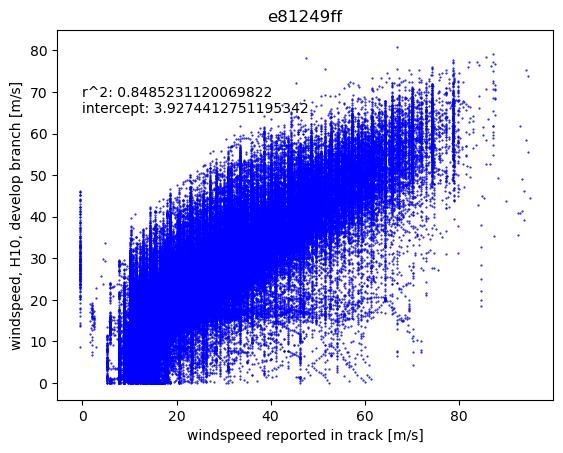

In [15]:
label_select = 'e81249ff' # corresponds to current develop branch
selection = (results_df['git_label']==label_select) & (results_df.windspeed_climada > 0)
lin_regress_result = linregress(
    results_df[selection].windspeed_tracks,
    results_df[selection].windspeed_climada,
)
plt.plot(results_df[selection].windspeed_tracks,
         results_df[selection].windspeed_climada,
        '.b',
        markersize=1)
plt.xlabel('windspeed reported in track [m/s]')
plt.ylabel('windspeed, ' + model + ', develop branch [m/s]')
plt.title(label_select)
plt.text(x=0,
         y=65,
         s='r^2: ' + str(lin_regress_result.rvalue) + '\n' + 'intercept: ' + str(lin_regress_result.intercept),
        )

Text(0, 65, 'r^2: 0.8886264699623839\nintercept: 1.6908376475577391')

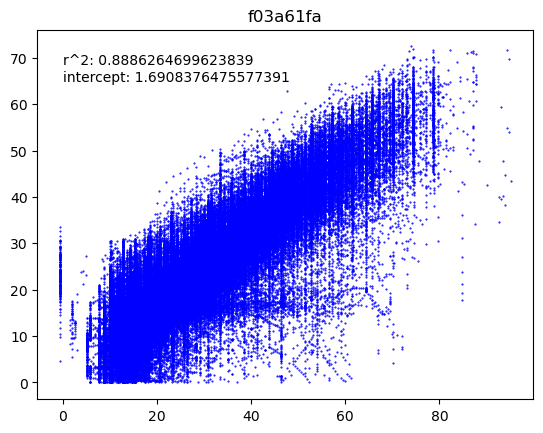

In [9]:
label_select = 'f03a61fa' # corresponds to current feature/tc_holland_vtrans branch
selection = (results_df['git_label']==label_select) & (results_df.windspeed_climada > 0)
lin_regress_result = linregress(
    results_df[selection].windspeed_tracks,
    results_df[selection].windspeed_climada,
)
plt.plot(results_df[selection].windspeed_tracks,
         results_df[selection].windspeed_climada,
        '.b',
        markersize=1)
plt.title(label_select)
plt.xlabel('windspeed reported in track [m/s]')
plt.ylabel('windspeed, ' + model + ', develop branch [m/s]')
plt.text(x=0,
         y=65,
         s='r^2: ' + str(lin_regress_result.rvalue) + '\n' + 'intercept: ' + str(lin_regress_result.intercept),
        )

In [7]:
label

'f03a61fa'